In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = f"../make_data/data_mapping_filtered.csv"
# Ensure to include 'ships_idx' in the fields list
fields = ['ships_idx', 'tag_name', 'tag_description', 'thing', 'property']

# Load the dataset
try:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields)
except UnicodeDecodeError:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields, encoding='ISO-8859-1')



## Problem: sample by ships_idx while maintaining overall row count proportion

To illustrate the problem: splitting by ship_idx alone might not lead to fair distribution of observation count since ship_idx do not share uniform counts. 

If sampling is bad, ships 1,29,31,2001,2003 in the same group might lead to a severe undercount for that splitted group.

We have to perform our own sampling based on the overall proportion of counts in the group

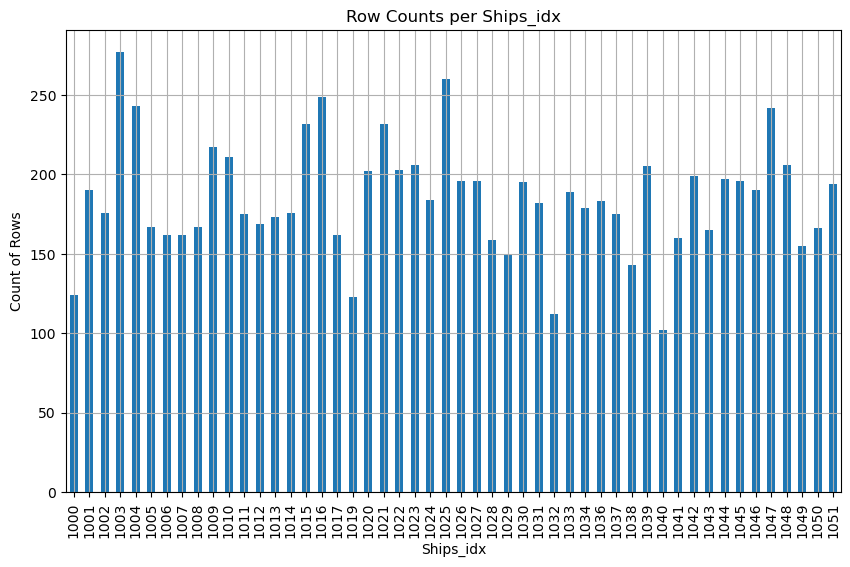

In [2]:
# Group the data by 'ships_idx' and count the rows for each group
row_counts = df.groupby('ships_idx').size()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
row_counts.plot(kind='bar')  # You can also use 'barh' for a horizontal bar plot
plt.title('Row Counts per Ships_idx')
plt.xlabel('Ships_idx')
plt.ylabel('Count of Rows')
plt.grid(True)
plt.show()


In [3]:
total_counts = sum(row_counts)
print(total_counts)

9278


In [4]:
import random


# function purpose: randomly sample until total counts hit the required proportion
# argument 1: dictionary of ship_idx to count
# argument 2: target proportion of total counts in argument 1
# argument 3: seed for random generator
def sample_idx_until_proportion(count_by_ship_idx, target_proportion, seed):

    random.seed(seed)
    ship_idx_list = list(count_by_ship_idx.keys())

    total_count = sum(count_by_ship_idx.values())
    target_count = int(total_count * target_proportion)

    selected_ships = []
    total_selected_counts = 0

    # sample ship_idx until counts are close enough to target
    # add a buffer of 100 to stop once close enough
    while (total_selected_counts < target_count - 100): 
        
        # Select a ship using random sampling without replacement
        chosen_ship_idx = random.choice(ship_idx_list)
        counts = count_by_ship_idx[chosen_ship_idx]
        
        # Add the chosen ship to the selected ship list
        selected_ships.append(chosen_ship_idx)
        total_selected_counts += counts

        # remove selected ship from sampling list
        ship_idx_list.remove(chosen_ship_idx)
    return selected_ships, total_selected_counts
    

In [5]:
seed = 43
count_by_ship_idx = df.groupby('ships_idx').size().to_dict()

total_ship_idx_set = set(count_by_ship_idx.keys())
# sample idx's for training data
training_ship_idx_selection, training_counts = sample_idx_until_proportion(count_by_ship_idx, 0.95, seed=seed)
val_test_ship_idx_set = total_ship_idx_set - set(training_ship_idx_selection)
# sample idx's for validation data
count_by_ship_idx_val_test_set = { ship_idx: count_by_ship_idx[ship_idx] for ship_idx in list(val_test_ship_idx_set) }
# note that 0.5 is for the ship_idx set that remains after removing training ship_idx's
# set to 1.0 to fully set no ships for test
# we want to maximize the full training data set
val_ship_idx_selection, validation_counts = sample_idx_until_proportion(count_by_ship_idx_val_test_set, 1.0, seed=seed)
# sample idx's for test data
test_ship_idx_selection = val_test_ship_idx_set - set(val_ship_idx_selection)

# get report of split
total_counts = sum(count_by_ship_idx.values())
print("training proportion: ", training_counts/total_counts)
print("validation proportion: ", validation_counts/total_counts)
print("test proportion: ", (total_counts - training_counts - validation_counts)/total_counts)


print("training ship idx selection:")
print(training_ship_idx_selection)

print("validation ship idx selection:")
print(val_ship_idx_selection)

print("testing ship idx selection:")
print(test_ship_idx_selection)

train_idx = training_ship_idx_selection
test_idx = test_ship_idx_selection
validation_idx = val_ship_idx_selection

training proportion:  0.9464324207803406
validation proportion:  0.05356757921965941
test proportion:  0.0
training ship idx selection:
[1002, 1020, 1048, 1010, 1033, 1027, 1050, 1007, 1037, 1047, 1040, 1051, 1001, 1043, 1036, 1030, 1039, 1034, 1015, 1003, 1045, 1006, 1046, 1008, 1022, 1011, 1009, 1014, 1032, 1031, 1013, 1028, 1044, 1023, 1017, 1021, 1004, 1000, 1041, 1005, 1019, 1012, 1025, 1026, 1029, 1016, 1024]
validation ship idx selection:
[1049, 1038, 1042]
testing ship idx selection:
set()


# process tag_description

we want to add special marker tokens flanking the '#' of the MDM

In [6]:
import tqdm as tqdm

In [7]:

tag_desc = df['tag_description'].to_list()

In [8]:
tag_desc

['M/E LOAD ',
 'M/E RPM SIGNAL',
 'M/E T/C RPM',
 'M/E T/C L.O INLET PRESS L / SLOWDOWN',
 'M/E F.O INLET PRESS L',
 'ME RPM',
 'M/E MAIN LO INLET PRESS',
 'M/E MAIN LO INLET TEMP',
 'M/E JACKET C.F.W INLET PRESS L / SLOW DOWN',
 'M/E SCAV. AIR RECEIVER PRESS ',
 'M/E L.O INLET TO MAIN BRG & THR. BRG PRESS L / SLOWDOWN',
 'M/E NO.1 CYL. EXH GAS OUTLET TEMP H',
 'M/E T/C LO INLET TEMP',
 'M/E T/C LO INLET PRESS',
 'M/E T/C LO OUTLET TEMP',
 'ME 1 CYL PCO OUTLET TEMP',
 'M/E NO.2 CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.3 CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.4 CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.5 CYL. EXH GAS OUTLET TEMP H',
 'ME 2 CYL PCO OUTLET TEMP',
 'ME 3 CYL PCO OUTLET TEMP',
 'M/E NO.6 CYL. EXH GAS OUTLET TEMP H',
 'M/E T/C EXH GAS INLET TEMP H',
 'M/E T/C EXH GAS OUTLET TEMP H',
 'M/E T/C L.O OUTLET TEMP H',
 'M/E SCAV. AIR RECEIVER TEMP H',
 'M/E NO.1 CYL. COVER C.W. OUTLET TEMP H',
 'M/E NO.2 CYL. COVER C.W. OUTLET TEMP H',
 'M/E NO.3 CYL. COVER C.W. OUTLET TEMP H',
 'M/E NO.4

In [9]:
def find_matching_strings(strings, diff_count):
    
    family_of_f = []
    ignore_list = set()
    first_time = True
    counter = 0 
    for i in tqdm.tqdm(range(len(strings))):
        # print("i is ", i)
        if (strings[i] in ignore_list):
            continue
        family = []
        for j in range(i + 1,len(strings)):
            # print("j is ", j)
            if (strings[j] in ignore_list):
                continue
            mismatch_count = 0

            # find number of corresponding differences
            if len(strings[i]) == len(strings[j]):
                for k in range(len(strings[i])):
                    if strings[i][k] != strings[j][k]:
                        mismatch_count += 1
                        if mismatch_count > diff_count:
                            break
            else:
                continue

            if (mismatch_count > 0 and mismatch_count <= diff_count and first_time):
                family.append((strings[i], i))
                family.append((strings[j], j))
                ignore_list.add(strings[i])
                ignore_list.add(strings[j])
                first_time = False
            elif (mismatch_count > 0 and mismatch_count <= diff_count and (not first_time)):
                family.append((strings[j], j))
                ignore_list.add(strings[j])
            else:
               pass 
        if (len(family)) > 0:
            family_of_f.append(family)
        first_time = True
        
    return family_of_f

Now that I have groups of families, how do i translate it to a processed column of processed values for tag_description?

We can try to save the index information together with the string.

Then we just iterate through the processed list and process one family at a time

In [10]:
family_list = find_matching_strings(tag_desc, 2)

100%|██████████| 9278/9278 [00:00<00:00, 14612.04it/s]


In [11]:
len(family_list)

839

we need a function where we try to find all the indices where the characters are different

Then at those indices, we flank the character with the \<attn\> token

In [12]:
def find_diff_char(strings):
    reference = strings[0][0]
    flank_pos = set()
    for sample in strings:
        for i in range(len(reference)):
            if reference[i] != sample[0][i]:
                flank_pos.add(i)
    return flank_pos


In [13]:
# function to insert <attn>
def mutate_list(tag_desc, family):
    indices = find_diff_char(family)
    for num in range(len(indices)):
        # re-compute differences in family after a single pass
        updated_indices = find_diff_char(family)
        # since we already know how many differences there are
        # and the positions are by index positions
        # we just take the values and sort and take the num-th value
        updated_indices = sorted(list(updated_indices))
        for index, tuple in enumerate(family):
            word = tuple[0]
            id = updated_indices[num]
            part1 = word[:id]
            part2 = word[id]
            part3 = word[id + 1:]
            tag_desc[tuple[1]] = part1 + "<attn>" + part2 + "<attn>" + part3
            word = tag_desc[tuple[1]]
            # update family item too
            family[index] = (word, tuple[1])


    # for tuple in family:
    #     print(tag_desc[tuple[1]])



In [14]:
for family in family_list:
    mutate_list(tag_desc, family)

In [15]:
family_list[0]

[('M/E R<attn>P<attn><attn>M<attn> SIGNAL', 1),
 ('M/E R<attn>U<attn><attn>N<attn> SIGNAL', 4727)]

In [16]:
# save result back to df
new_df = pd.DataFrame({'tag_description_with_tokens': tag_desc})
df = pd.concat([df, new_df], axis=1)
df['tag_description_with_tokens'] = df['tag_description_with_tokens'].astype('string')




In [17]:
[word for word in df['tag_description_with_tokens']]

['M/E LOAD ',
 'M/E R<attn>P<attn><attn>M<attn> SIGNAL',
 'M/E T/C<attn> <attn>RPM',
 'M/E T/C L.O INLET PRESS L / SLOWDOWN',
 'M/E F.O INLET PRESS L',
 'ME R<attn>P<attn><attn>M<attn>',
 'M/E MAIN LO INLET PRESS',
 'M/E MAIN LO INLET TEMP',
 'M/E JACKET C.F.W INLET PRESS L / SLOW DOWN',
 'M/E SCAV. AIR RECEIVER PRESS<attn> <attn>',
 'M/E L.O INLET TO MAIN BRG & THR. BRG PRESS L / SLOWDOWN',
 'M/E NO.<attn>1<attn> CYL. EXH GAS OUTLET TEMP H',
 'M/E T/C LO INLET TEMP',
 'M/E T/C LO INLET PRESS',
 'M/E T/C LO OUTLET TEMP',
 'ME <attn>1<attn> CYL PCO OUTLET TEMP',
 'M/E NO.<attn>2<attn> CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.<attn>3<attn> CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.<attn>4<attn> CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.<attn>5<attn> CYL. EXH GAS OUTLET TEMP H',
 'ME <attn>2<attn> CYL PCO OUTLET TEMP',
 'ME <attn>3<attn> CYL PCO OUTLET TEMP',
 'M/E NO.<attn>6<attn> CYL. EXH GAS OUTLET TEMP H',
 'M/E T/C EXH GAS INLET TEMP H',
 'M/E T/C EXH GAS OUTLET TEMP H',
 'M/E T/C L.O OUTLET TE

In [18]:
len(df['tag_description_with_tokens']) 

9278

In [19]:
len(df['tag_description'])

9278

In [20]:
df.columns

Index(['thing', 'property', 'ships_idx', 'tag_name', 'tag_description',
       'tag_description_with_tokens'],
      dtype='object')

# produce columnar data to disk

In [21]:
# Filter the DataFrame based on the split indices
train_df = df[df['ships_idx'].isin(train_idx)]
# test_df = df[df['ships_idx'].isin(test_idx)]
validation_df = df[df['ships_idx'].isin(validation_idx)]


In [22]:
train_df

,thing,property,ships_idx,tag_name,tag_description,tag_description_with_tokens
0,MainEngine1Thing,Load,1025,MB.KM.IAS.Q1.A400001,M/E LOAD,M/E LOAD
1,MainEngine1Thing,RPM,1025,MB.KM.IAS.Q1.A400002,M/E RPM SIGNAL,M/E R<attn>P<attn><attn>M<attn> SIGNAL
2,ME1TurboCharger1Thing,RPM,1025,MB.KM.IAS.Q1.A400003,M/E T/C RPM,M/E T/C<attn> <attn>RPM
3,ME1TurboCharger1Thing,LOInletPress,1025,MB.KM.IAS.Q1.A400004,M/E T/C L.O INLET PRESS L / SLOWDOWN,M/E T/C L.O INLET PRESS L / SLOWDOWN
4,MainEngine1Thing,FOInletPress,1025,MB.KM.IAS.Q1.A400005,M/E F.O INLET PRESS L,M/E F.O INLET PRESS L
...,...,...,...,...,...,...
9273,MainEngine1Thing,CFWOutletPress,1033,MW005,M/E JCW COMMON OUT PRESS,M/E JCW COMMON OUT PRESS
9274,MainEngine1Thing,CFWOutletPress,1043,MW_PT8413_Y,M/E JACKET COOLING FRESH WATER COMMON OUTLET P...,M/E JACKET COOLING FRESH WATER COMMON OUTLET P...
9275,MainEngine1Thing,CFWOutletPress,1045,MW006,M/E JACKET C.W COMMON OUT PRESS,M/E JACKET C.W COMMON OUT PRESS
9276,MainEngine1Thing,CFWOutletPress,1048,MW009,M/E J.C.F.W OUTLET PRESS,M/E J.C.F.W OUTLET PRESS


In [23]:
import json
from datasets import Dataset, DatasetDict


# convert each dataframe row into a dictionary
# outputs a list of dictionaries
def process_df(df):
    output_list = [{
        'translation': {
            'ships_idx': row['ships_idx'],
            'tag_description': row['tag_description_with_tokens'],
            'thing_property': f"<THING_START>{row['thing']}<THING_END><PROPERTY_START>{row['property']}<PROPERTY_END>",
            'answer': f"{row['thing']} {row['property']}",

        }
    } for _, row in df.iterrows()]

    return output_list


combined_data = DatasetDict({
    'train': Dataset.from_list(process_df(train_df)),
    # 'test' : Dataset.from_list(process_df(test_df)),
    'validation' : Dataset.from_list(process_df(validation_df)),
})



combined_data.save_to_disk("combined_data")

Saving the dataset (0/1 shards):   0%|          | 0/8781 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/497 [00:00<?, ? examples/s]

# benchmark reference

In [24]:
import json
from datasets import Dataset, DatasetDict


# convert each dataframe row into a dictionary
# outputs a list of dictionaries
def process_df(df):
    output_list = [{
        'translation': {
            'ships_idx': row['ships_idx'],
            'tag_description': row['tag_description'],
            'thing_property': f"<THING_START>{row['thing']}<THING_END><PROPERTY_START>{row['property']}<PROPERTY_END>",
            'answer': f"{row['thing']} {row['property']}",

        }
    } for _, row in df.iterrows()]

    return output_list


combined_data = DatasetDict({
    'train': Dataset.from_list(process_df(train_df)),
    # 'test' : Dataset.from_list(process_df(test_df)),
    'validation' : Dataset.from_list(process_df(validation_df)),
})



combined_data.save_to_disk("combined_data_reference")

Saving the dataset (0/1 shards):   0%|          | 0/8781 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/497 [00:00<?, ? examples/s]